In [1]:
# for not jacking yourself
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo
import scipy.interpolate as itp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # surface plots
import time as time # for timing later
import glob as glob # for grepping files

from tqdm import tqdm # fancy progress bar

## Test opening files

t
[  0.           3.68686869   7.37373737  11.06060606  14.74747475
  18.43434343  22.12121212  25.80808081  29.49494949  33.18181818
  36.86868687  40.55555556  44.24242424  47.92929293  51.61616162
  55.3030303   58.98989899  62.67676768  66.36363636  70.05050505
  73.73737374  77.42424242  81.11111111  84.7979798   88.48484848
  92.17171717  95.85858586  99.54545455 103.23232323 106.91919192
 110.60606061 114.29292929 117.97979798 121.66666667 125.35353535
 129.04040404 132.72727273 136.41414141 140.1010101  143.78787879
 147.47474747 151.16161616 154.84848485 158.53535354 162.22222222
 165.90909091 169.5959596  173.28282828 176.96969697 180.65656566
 184.34343434 188.03030303 191.71717172 195.4040404  199.09090909
 202.77777778 206.46464646 210.15151515 213.83838384 217.52525253
 221.21212121 224.8989899  228.58585859 232.27272727 235.95959596
 239.64646465 243.33333333 247.02020202 250.70707071 254.39393939
 258.08080808 261.76767677 265.45454545 269.14141414 272.82828283
 276.515

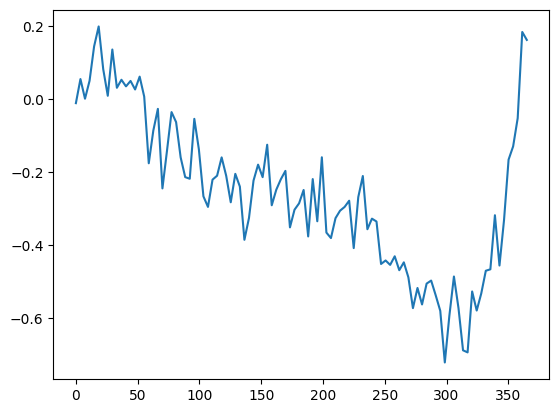

In [3]:
testPath = './data3.npz'

lala = np.load(testPath)

lst = lala.files
for item in lst:
    print(item)
    print(lala[item])
plt.plot(lala['t'], lala['d'])

## Bayesian parameter inference

In [4]:
fBase = './'
fName3 = 'data3.npz'
dataPkt3 = np.load(fBase+fName3)

In [5]:
lumi3 = dataPkt3['d']
time3 = dataPkt3['t']
err3 = dataPkt3['e']

### Declaring priors on the mean,$\mu_l^\alpha$, and uncertainty,$\sigma_l^{\alpha_l}$, of the coefficients, $\alpha_l$

In [6]:
priErr = 1. # prior on the uncertainty of the coeff
priMu = 0. # prior on the mean of the coeff

In [7]:
priMu, priErr

(0.0, 1.0)

### Constructing the posterior covariance matrix, $D^{P}_{lm}$

\begin{equation}
\left(D^P_{lm}\right)^{-1} = \frac{\delta^K_{lm}}{(\sigma_i^\alpha)^2} + \sum_i\frac{t_i^l t^m_i}{\sigma_i^2}
\end{equation}

In [8]:
maxPow = 8

myM = maxPow+1
detInv = np.zeros((myM, myM))

for iL in range(myM):
    for iM in range(myM):
        tmp1 = np.power(time3, iL)
        tmp2 = np.power(time3, iM)
        tmp3 = (tmp1*tmp2)/np.power(err3, 2)
        detInv[iL, iM] = np.sum(tmp3)

detInv = detInv + np.eye(myM)/np.power(priErr, 2)
det = np.linalg.inv(detInv)

In [9]:
np.shape(det)

(9, 9)

### Constructing the A thing
\begin{equation}
A_l = \frac{\mu_l^\alpha}{(\sigma_i^\alpha)^2} + \sum_i\frac{t_i^l d_i}{\sigma_i^2}
\end{equation}

In [10]:
A = np.ones(myM)*(priMu/np.power(priErr,2))

for iL in range(myM):
    tmp1 = np.power(time3, iL)
    tmp2 = (tmp1*lumi3)/(err3**2)
    A[iL] += np.sum(tmp2)

In [11]:
A, len(A)

(array([-4.10580177e+02, -1.00228447e+05, -2.62800051e+07, -7.29501449e+09,
        -2.10229636e+12, -6.21452569e+14, -1.87089745e+17, -5.71030749e+19,
        -1.76167176e+22]),
 9)

### Caculating the posterior mean, $\mu_l^P$
\begin{equation}
\mu_l^P = \sum_m D^P_{lm}A_m
\end{equation}

This object, $\mu_l^P$, also corresponds to the Maximum A Posterior (MAP) estimate for the coefficients, $\alpha_i$.

In [12]:
mu = np.ones(myM)*np.nan

for iM in range(myM):
    mu[iM] = np.sum(det[iM,]*A)
print(mu)

[-1.99103112e-02  1.56163354e-02 -6.25906797e-04  9.47318713e-06
 -7.88506077e-08  3.91409107e-10 -1.14601048e-12  1.80396862e-15
 -1.16188162e-18]


### Making predictions
\begin{equation}
s_i = \sum_m\mu_m^Pt^m_i
\end{equation}

In [13]:
sHat = np.zeros(np.shape(time3))
for iM in range(myM):
    sHat+=mu[iM]*np.power(time3, iM)

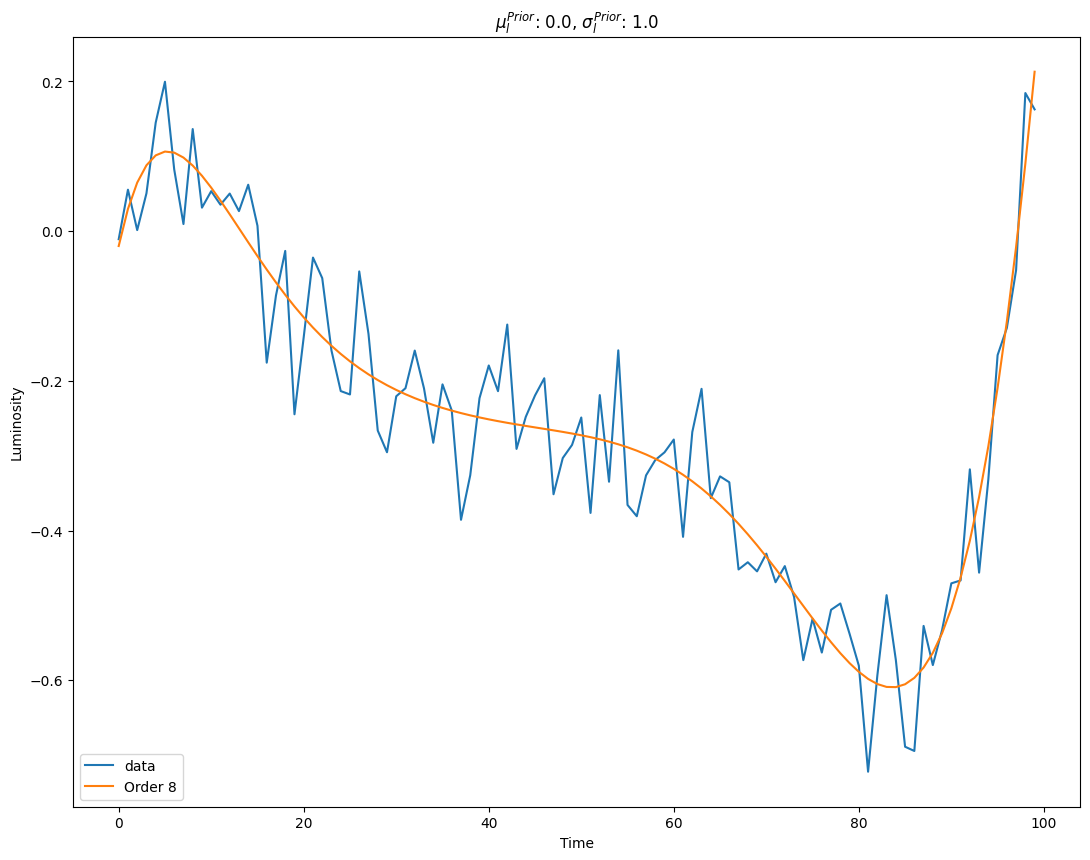

In [14]:
plt.figure(figsize=(13, 10), facecolor='w')
plt.plot(lumi3, label='data')
plt.plot(sHat, label='Order %i' % maxPow)
plt.xlabel('Time')
plt.ylabel('Luminosity')

plt.title(f'$\mu_l^{{Prior}}$: {priMu}, $\sigma_l^{{Prior}}$: {priErr}')

plt.legend()

### Defining function to calculate coeff for given power, m

In [15]:
def calCoeff(m):
    myM = m+1
    # Calculating D
    detInv = np.zeros((myM, myM))

    for iL in range(myM):
        for iM in range(myM):
            tmp1 = np.power(time3, iL)
            tmp2 = np.power(time3, iM)
            tmp3 = (tmp1*tmp2)/np.power(err3, 2)
            detInv[iL, iM] = np.sum(tmp3)

    detInv = detInv + np.eye(myM)/np.power(priErr, 2)
    det = np.linalg.inv(detInv)
    
    # Calculating A
    A = np.ones(myM)*(priMu/np.power(priErr,2))

    for iL in range(myM):
        tmp1 = np.power(time3, iL)
        tmp2 = (tmp1*lumi3)/(err3**2)
        A[iL] += np.sum(tmp2)
    print(A)
    # Calculating the coefficients
    mu = np.ones(myM)*np.nan

    for iM in range(myM):
        mu[iM] = np.sum(det[iM,]*A)
    return mu, detInv, det
    

### Defining function to calculate predictions given model coefficients and time values

In [16]:
def calPred(mu, m):
    myM = m+1
    sHat = np.zeros(np.shape(time3))
    for iM in range(myM):
        sHat+=mu[iM]*np.power(time3, iM)
    return sHat

In [17]:
nyan, dmp, dmp = calCoeff(maxPow)
nyan2 = calPred(nyan, maxPow)
print(sHat-nyan2)

[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19
 -1.76167176e+22]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [18]:
len(nyan2)

100

### Plotting all models out

In [19]:
modelBag = np.arange(1,9) # rmb that arange doesn't include end point, it's a [)
coeffBag = []
predBag = []
for iM in modelBag:
    tmp, dmp, dmp = calCoeff(iM)
    tmpOut = calPred(tmp, iM)
    coeffBag.append(tmp)
    predBag.append(tmpOut)

[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19
 -1.76167176e+22]


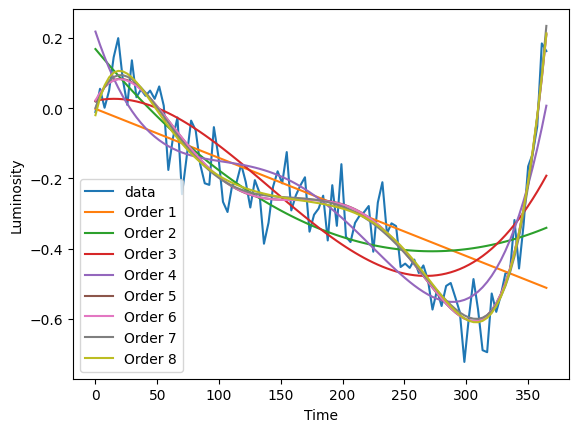

In [20]:
plt.plot(time3, lumi3, label='data')
for iM, locM in enumerate(modelBag):
    plt.plot(time3, predBag[iM], label='Order %i' % locM)
plt.xlabel('Time')
plt.ylabel('Luminosity')

plt.legend()

## Bayesian model testing
### Bayes Factor
The various model can be ranked according to the Bayes Factor, which is defined as a ratio of the evidence for the different models, $\pi(\{d_i\}|M=m)$. For instance,
\begin{equation}
BF_{2,4} = \frac{\pi(\{d_i\}|M=2)}{\pi(\{d_i\}|M=4)}
\end{equation}


### Calculating the evidence, $\pi(\{d_i\}|M)$
\begin{alignat}{2}
\pi(\{d_i\}|M) &= \int d\{\alpha_l\} \pi\left(\{\alpha_l\}|M\right) \pi\left(\{d_i\}|\{\alpha_l\},M\right)\\
&= \sqrt{\det(2\pi D^P)}\qquad\qquad\qquad\qquad&&\Bigg\}\text{Part 1. Reflects complexity of model.}\\
&\times \exp\left(\frac{1}{2}\sum_{lm}\mu_l^P(D_{lm}^P)^{-1}\mu_m^P\right)&&\Bigg\}\text{Part 2. Dunno what this is called.}\\
&\times\prod_l\frac{\exp\left(-\frac{1}{2}\left(\frac{\mu_l^\alpha}{\sigma_l^\alpha}\right)^2\right)}{\sqrt{2\pi(\sigma_l^\alpha)^2}}&&\Bigg\}\text{Part 3. Prior volume, helps penalize complicated models}\\
&\times\prod_i\frac{\exp\left(-\frac{1}{2}\left(\frac{d_i}{\sigma_i}\right)^2\right)}{\sqrt{2\pi(\sigma_i)^2}}&&\Bigg\}\text{Part 4. Only depends on data}
\end{alignat}

Since part 4 is only a function of the data, it will cancel in the computation of the Bayes Factor, so shan't bother calculating it in the non-log version of the Bayes Factor.

In [21]:
maxPow = 8 
myM = maxPow+1

mu, dInv, d = calCoeff(maxPow)

# part 1
part1 = np.sqrt(np.linalg.det(2*np.pi*d))

# part 2
tmpBag = 0
for iL in range(myM):
    for iM in range(myM):
        tmpBag += dInv[iL,iM]*mu[iL]*mu[iM]
part2 = np.exp(0.5*tmpBag)

# part 3
tmpTop = np.exp(-0.5*np.power((priMu/priErr),2))
tmp3 = tmpTop/(np.sqrt(2*np.pi)*priErr)
part3 = np.power(tmp3, myM)

# final evidence
chk = part1*part2*part3

[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19
 -1.76167176e+22]


In [22]:
dInv

array([[1.60100000e+03, 2.92000000e+05, 7.14121886e+07, 1.96473232e+10,
        5.76579908e+12, 1.76254710e+15, 5.54182436e+17, 1.77875433e+20,
        5.79982586e+22],
       [2.92000000e+05, 7.14121896e+07, 1.96473232e+10, 5.76579908e+12,
        1.76254710e+15, 5.54182436e+17, 1.77875433e+20, 5.79982586e+22,
        1.91472018e+25],
       [7.14121886e+07, 1.96473232e+10, 5.76579908e+12, 1.76254710e+15,
        5.54182436e+17, 1.77875433e+20, 5.79982586e+22, 1.91472018e+25,
        6.38494004e+27],
       [1.96473232e+10, 5.76579908e+12, 1.76254710e+15, 5.54182436e+17,
        1.77875433e+20, 5.79982586e+22, 1.91472018e+25, 6.38494004e+27,
        2.14688510e+30],
       [5.76579908e+12, 1.76254710e+15, 5.54182436e+17, 1.77875433e+20,
        5.79982586e+22, 1.91472018e+25, 6.38494004e+27, 2.14688510e+30,
        7.26914918e+32],
       [1.76254710e+15, 5.54182436e+17, 1.77875433e+20, 5.79982586e+22,
        1.91472018e+25, 6.38494004e+27, 2.14688510e+30, 7.26914918e+32,
        2.4

In [23]:
mu

array([-1.99103112e-02,  1.56163354e-02, -6.25906797e-04,  9.47318713e-06,
       -7.88506077e-08,  3.91409107e-10, -1.14601048e-12,  1.80396862e-15,
       -1.16188162e-18])

In [24]:
part2

np.float64(3.90267824008709e+37)

In [25]:
part3

np.float64(0.0002559708982027758)

In [26]:
chk

np.float64(6.074173954825676e-49)

### Defining function to calculate evidence given order

In [27]:
def calEv(m):
    myM = m+1
    mu, dInv, d = calCoeff(m)
    part1 = np.sqrt(np.linalg.det(2*np.pi*d))
    
    tmpBag = 0
    for iL in range(myM):
        for iM in range(myM):
            tmpBag += dInv[iL,iM]*mu[iL]*mu[iM]
    part2 = np.exp(0.5*tmpBag)
    
    tmpTop = np.exp(-0.5*np.power((priMu/priErr),2))
    tmp3 = tmpTop/(np.sqrt(2*np.pi)*priErr)
    part3 = np.power(tmp3, myM)
    
    tot = part1*part2*part3
    return tot, part1, part2, part3

In [28]:
test, p1, p2, p3 = calEv(maxPow)

print('Total:: explit: %e, function: %e, diff: %e' % (chk, test, chk-test))
print('Part1:: explit: %e, function: %e, diff: %e' % (part1, p1, part1-p1))
print('Part2:: explit: %e, function: %e, diff: %e' % (part2, p2, part2-p2))
print('Part3:: explit: %e, function: %e, diff: %e' % (part3, p3, part3-p3))

[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19
 -1.76167176e+22]
Total:: explit: 6.074174e-49, function: 6.074174e-49, diff: 0.000000e+00
Part1:: explit: 6.080424e-83, function: 6.080424e-83, diff: 0.000000e+00
Part2:: explit: 3.902678e+37, function: 3.902678e+37, diff: 0.000000e+00
Part3:: explit: 2.559709e-04, function: 2.559709e-04, diff: 0.000000e+00


In [29]:
testModelBag = np.arange(1,9)

totBag = []
p1Bag = []
p2Bag = []
p3Bag = []
for iM in testModelBag:
    tot, p1, p2, p3 = calEv(iM)
    totBag.append(tot)
    p1Bag.append(p1)
    p2Bag.append(p2)
    p3Bag.append(p3)

[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19
 -1.76167176e+22]


[1 2 3 4 5 6 7 8]


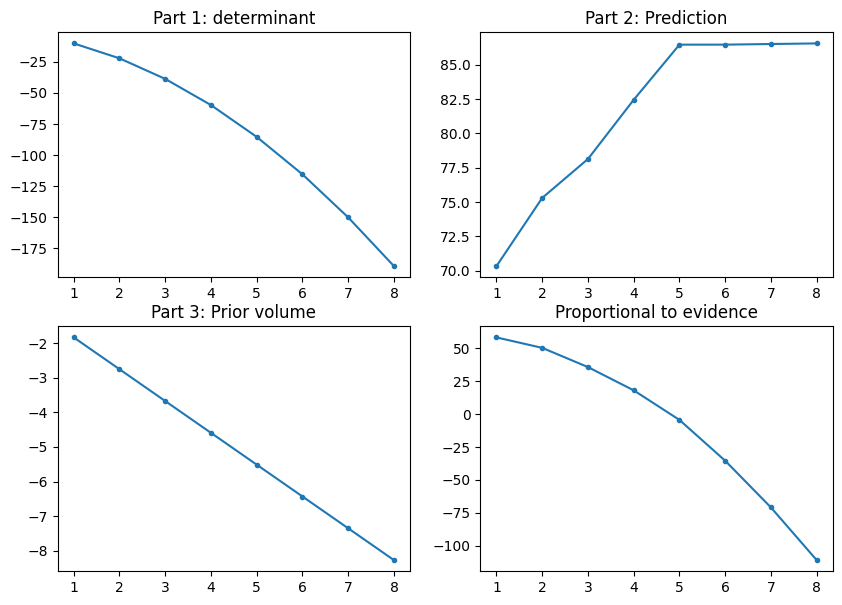

In [30]:
f1 = plt.figure(1, figsize=(10, 7))
f1.add_subplot(221)
plt.plot(testModelBag, np.log(p1Bag), '.-')
plt.title('Part 1: determinant')

f1.add_subplot(222)
plt.plot(testModelBag, np.log(p2Bag), '.-')
plt.title('Part 2: Prediction')

f1.add_subplot(223)
plt.plot(testModelBag, np.log(p3Bag), '.-')
plt.title('Part 3: Prior volume')

f1.add_subplot(224)
plt.plot(testModelBag, np.log(totBag), '.-')
plt.title('Proportional to evidence')

print(testModelBag)

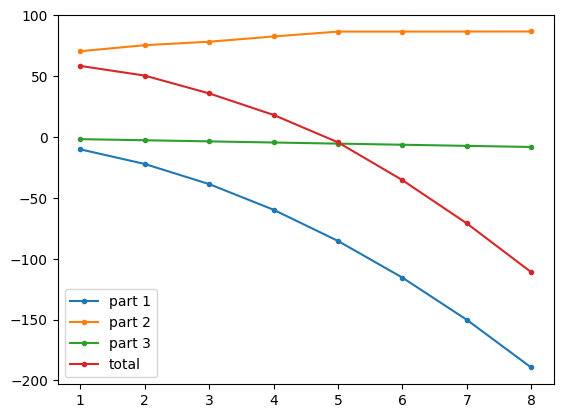

In [31]:
# To see composition
plt.plot(testModelBag, np.log(p1Bag), '.-', label='part 1')
plt.plot(testModelBag, np.log(p2Bag), '.-', label='part 2')
plt.plot(testModelBag, np.log(p3Bag), '.-', label='part 3')
plt.plot(testModelBag, np.log(totBag), '.-', label='total')
plt.legend()

### The ln version can be simplified

\begin{equation}
\ln\left[\pi(\{d_i\}|M)\right]\propto\ln\left(\det(2\pi D^P)\right)+\sum_{lm}\mu_l^P(D^P_{lm})^{-1}\mu_m^P - \left(M+1\right)\left(\frac{\mu_l^\alpha}{\sigma_l^\alpha}\right)^2-\left(M+1\right)\ln\left[2\pi\left(\sigma_l^\alpha\right)^2\right]
\end{equation}

In [32]:
def calLnEv(m):
    myM = m+1
    mu, dInv, d = calCoeff(m)
    part1 = np.log(np.linalg.det(2*np.pi*d))
    
    part2 = 0
    for iL in range(myM):
        for iM in range(myM):
            part2 += dInv[iL,iM]*mu[iL]*mu[iM]
    
    part3 = -1*myM*np.power((priMu/priErr),2)
    
    part4 = -1*myM*np.log(2*np.pi*np.power(priErr,2))
    
    #tot = part1+part2+part3+part4
    
    # The data chunk
    tmp = lumi3/err3
    tmp = np.sum(np.power(tmp,2))
    tmp2 = np.log(np.sum(err3**2)*2*np.pi)
    part5 = -1*(tmp-tmp2)
    tot = part1+part2+part3+part4+part5
    
    return tot, part1, part2, part3, part4

In [33]:
testPow = np.arange(1,9)

for iPow in testPow:
    test, p1, p2, p3, p4 = calLnEv(iPow)
    print('Order %i: %.4f' % (iPow, test))

[   -410.5801771  -100228.44659672]
Order 1: -59.2179
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07]
Order 2: -75.1104
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09]
Order 3: -104.3408
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12]
Order 4: -139.6836
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14]
Order 5: -184.6711
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17]
Order 6: -246.7404
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19]
Order 7: -317.7689
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19
 -1.76167176e+22]
Order 8: -397.8444


In [34]:
testModelBag = np.arange(1,9)

totBag = []
p1Bag = []
p2Bag = []
p3Bag = []
p4Bag = []
for iM in testModelBag:
    tot, p1, p2, p3, p4 = calLnEv(iM)
    totBag.append(tot)
    p1Bag.append(p1)
    p2Bag.append(p2)
    p3Bag.append(p3)
    p4Bag.append(p4)

[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19
 -1.76167176e+22]


[1 2 3 4 5 6 7 8]


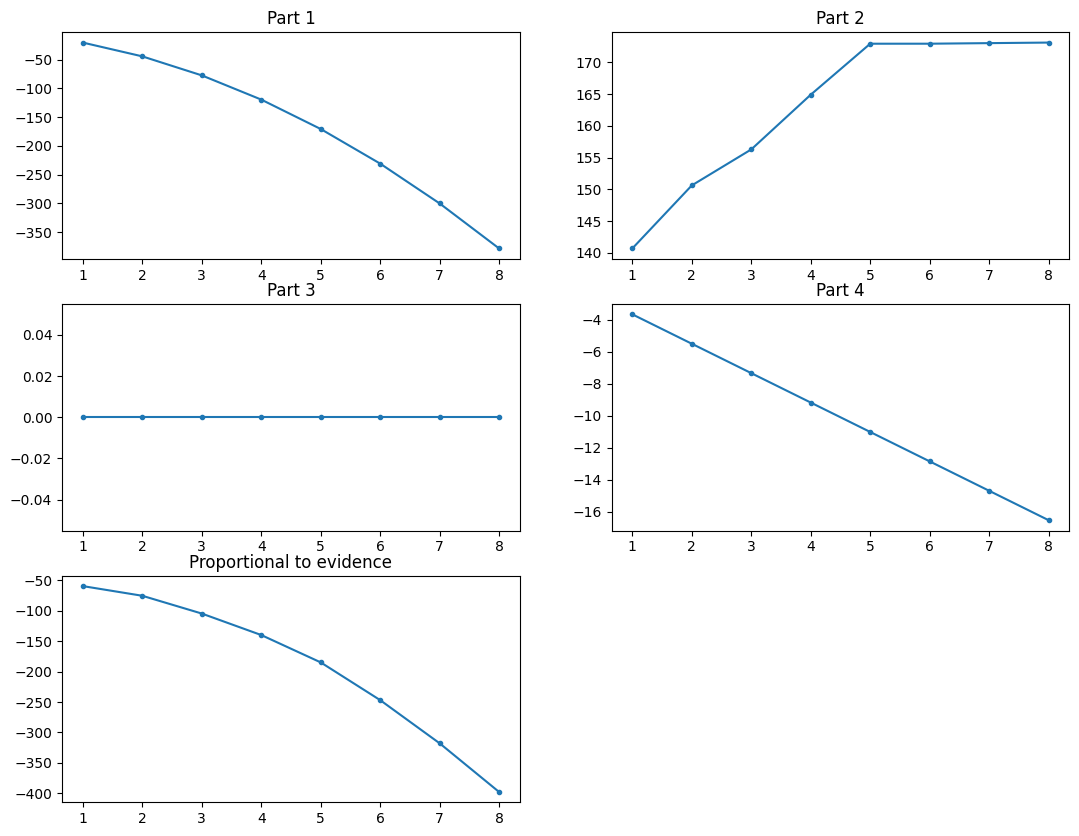

In [35]:
f10 = plt.figure(10, figsize=(13, 10))
f10.add_subplot(321)
plt.plot(testModelBag, p1Bag, '.-')
plt.title('Part 1')

f10.add_subplot(322)
plt.plot(testModelBag, p2Bag, '.-')
plt.title('Part 2')

f10.add_subplot(323)
plt.plot(testModelBag, p3Bag, '.-')
plt.title('Part 3')

f10.add_subplot(324)
plt.plot(testModelBag, p4Bag, '.-')
plt.title('Part 4')

f10.add_subplot(325)
plt.plot(testModelBag, totBag, '.-')
plt.title('Proportional to evidence')


print(testModelBag)

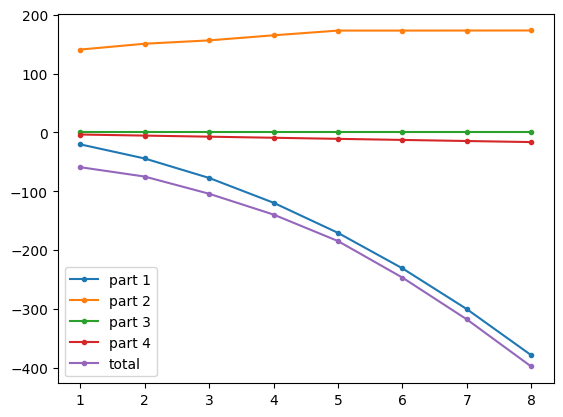

In [36]:
# To see composition
plt.plot(testModelBag, p1Bag, '.-', label='part 1')
plt.plot(testModelBag, p2Bag, '.-', label='part 2')
plt.plot(testModelBag, p3Bag, '.-', label='part 3')
plt.plot(testModelBag, p4Bag, '.-', label='part 4')
plt.plot(testModelBag, totBag, '.-', label='total')
plt.legend()

Somehow the determinant term dominates the evidence.

### Calculating evidence of all models

In [37]:
modelBag = np.arange(1, 9) # power 1 to 8
#modelBag = np.arange(1, 3) # smaller one just for eyeballing
#modelBag = [1, 8]
print(modelBag)

[1 2 3 4 5 6 7 8]


In [38]:
evBag = []
for iM in modelBag:
    ev, dmp, dmp, dmp = calEv(iM)
    evBag.append(ev)
    print('Order %i, Evidence %.4e' % (iM, ev))

[   -410.5801771  -100228.44659672]
Order 1, Evidence 2.0667e+25
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07]
Order 2, Evidence 7.3160e+21
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09]
Order 3, Evidence 3.2883e+15
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12]
Order 4, Evidence 6.9564e+07
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14]
Order 5, Evidence 1.1843e-02
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17]
Order 6, Evidence 3.9381e-16
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19]
Order 7, Evidence 1.4848e-31
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19
 -1.76167176e+22]
Order 8, Evidence 6.0742e-49


### Defining function to calculate BF

In [39]:
def calLnBF(top,bottom):
    topEv, dmp, dmp, dmp, dmp = calLnEv(top)
    bottomEv, dmp, dmp, dmp, dmp = calLnEv(bottom)
    
    return topEv-bottomEv

In [40]:
def calBF(top,bottom):
    topEv, dmp, dmp, dmp = calEv(top)
    bottomEv, dmp, dmp, dmp = calEv(bottom)
    
    return topEv/bottomEv

In [41]:
bfBag = np.zeros((len(modelBag),len(modelBag)))

for indM, locM in enumerate(modelBag):
    for indM2, locM2 in enumerate(modelBag):
        bfBag[indM, indM2] = calBF(locM, locM2)
bfLogBag = np.log(bfBag)
print('BF bag')
print(bfBag)

print('Log BF bag')
print(bfLogBag)

[   -410.5801771  -100228.44659672]
[   -410.5801771  -100228.44659672]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19
 -

[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14 -2.14800597e+17 -6.64134342e+19
 -2.07584591e+22]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14 -2.14800597e+17 -6.64134342e+19
 -2.07584591e+22]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14 -2.14800597e+17 -6.64134342e+19
 -2.07584591e+22]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14 -2.14800597e+17 -6.64134342e+19
 -2.07584591e+22]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14 -2.14800597e

In [42]:
bfLnBag = np.zeros((len(modelBag),len(modelBag)))

for indM, locM in enumerate(modelBag):
    for indM2, locM2 in enumerate(modelBag):
        bfLnBag[indM, indM2] = calLnBF(locM, locM2)

[   -410.5801771  -100228.44659672]
[   -410.5801771  -100228.44659672]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19]
[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19
 -

[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14 -2.14800597e+17 -6.64134342e+19]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14 -2.14800597e+17 -6.64134342e+19]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14 -2.14800597e+17 -6.64134342e+19]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14 -2.14800597e+17 -6.64134342e+19]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14 -2.14800597e+17]
[-4.23651678e+02 -1.06268380e+05 -2.84437462e+07 -8.03181759e+09
 -2.34965936e+12 -7.04202236e+14 -2.14800597e+17

[1 2 3 4 5 6 7 8]


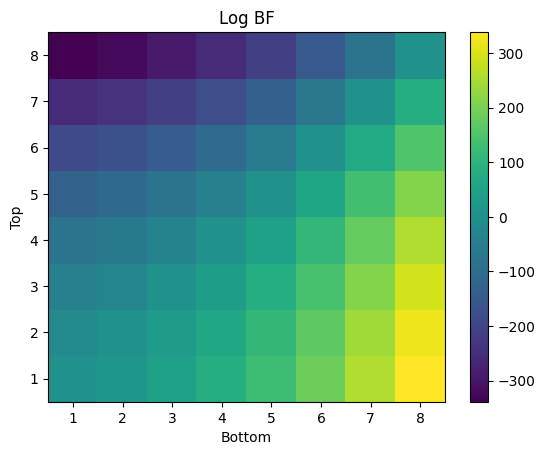

In [43]:
modelEdge = np.append(modelBag, [modelBag[-1]+1])-0.5

f0 = plt.figure(0)
c = plt.pcolor(modelEdge, modelEdge, bfLnBag)
plt.xlabel('Bottom')
plt.ylabel('Top')
plt.title('Log BF')
f0.colorbar(c)
print(modelBag)

[1 2 3 4 5 6 7 8]


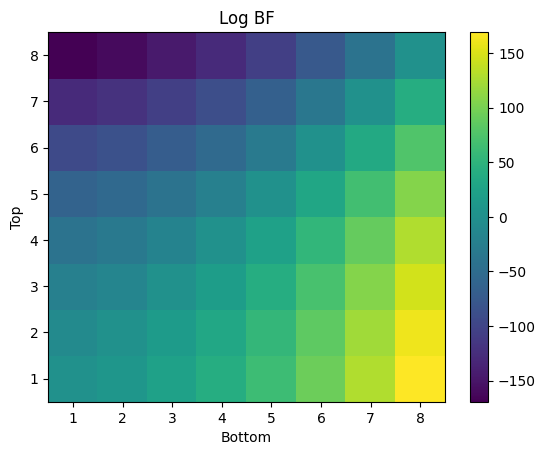

In [44]:
modelEdge = np.append(modelBag, [modelBag[-1]+1])-0.5

f0 = plt.figure(0)
c = plt.pcolor(modelEdge, modelEdge, bfLogBag)
plt.xlabel('Bottom')
plt.ylabel('Top')
plt.title('Log BF')
f0.colorbar(c)
print(modelBag)

According to this Bayes Factor, the model with order 1(linear) is preferred. But common sense and my eyeballs tell me that the model with order 5 should be preferred since it's looks well-fitted without being overfitting.

The reason why the model with order 1 is preferred is because the evidence is dominated by the determinant term $\sqrt{\det{2\pi D^P}}$, which is bigger for models with lower order.

## Frequentist goodness of fit test

In [45]:
modelBag

array([1, 2, 3, 4, 5, 6, 7, 8])

[   -410.5801771  -100228.44659672]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19]
[-4.10580177e+02 -1.00228447e+05 -2.62800051e+07 -7.29501449e+09
 -2.10229636e+12 -6.21452569e+14 -1.87089745e+17 -5.71030749e+19
 -1.76167176e+22]


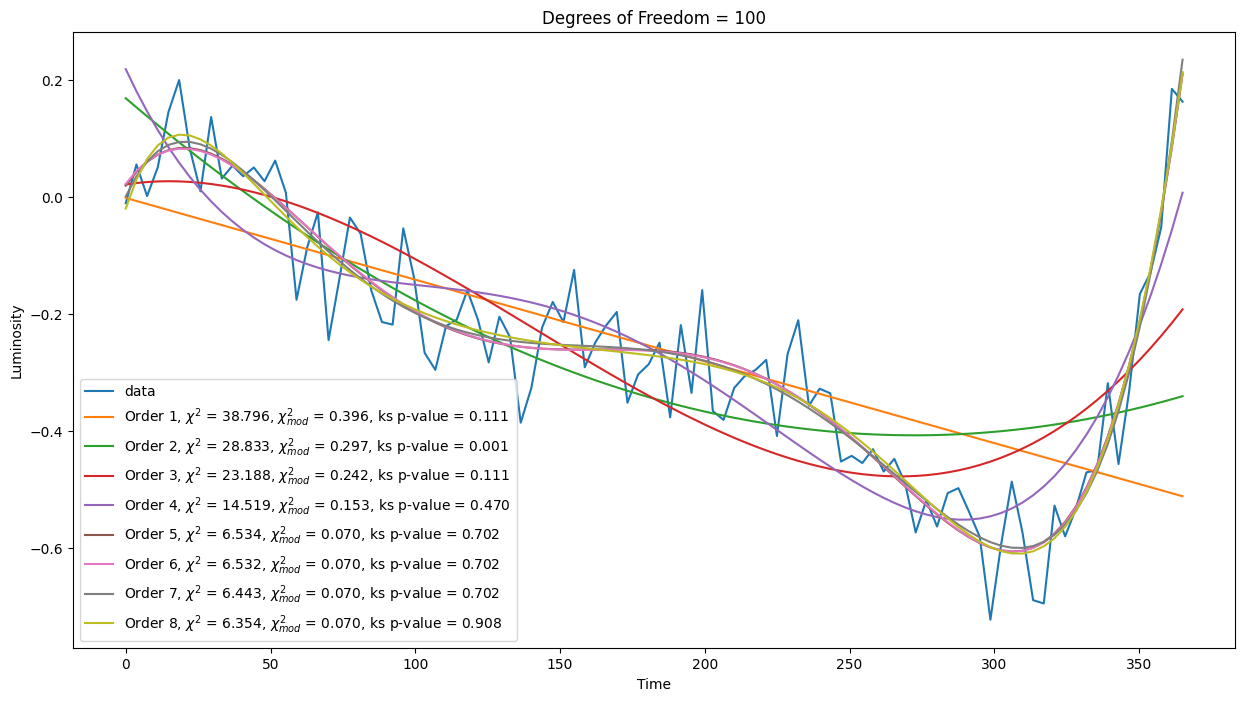

In [46]:
# Repeating older calculation for safety
modelBag = np.arange(1,9) # rmb that arange doesn't include end point, it's a [)
coeffBag = []
predBag = []
chiBag = []
chimodBag = []
ksBag = []

for iM in modelBag:
    tmp, dmp, dmp = calCoeff(iM)
    tmpOut = calPred(tmp, iM)
    
    tmpChi = np.sum(np.power((lumi3-tmpOut)/err3,2))
    tmpKs = sps.ks_2samp(lumi3, tmpOut)
    
    coeffBag.append(tmp)
    predBag.append(tmpOut)
    chimodBag.append(tmpChi/(len(lumi3)-iM-1))
    chiBag.append(tmpChi)
    ksBag.append(tmpKs.pvalue)

plt.figure(20, figsize=(15, 8))
plt.plot(time3, lumi3, label='data')
for iM, locM in enumerate(modelBag):
    plt.plot(time3, predBag[iM], label=r'Order %i, $\chi^2$ = %.3f, $\chi^2_{mod}$ = %.3f, ks p-value = %.3f' %\
             (locM, chiBag[iM], chimodBag[iM], ksBag[iM]))
plt.xlabel('Time')
plt.ylabel('Luminosity')
plt.title('Degrees of Freedom = %i' % len(time3))

plt.legend()

The model with a degree 5 polynomial is preferred since it has the highest ks-test p-value and the lowest $\chi^2$. Very informally, by eye, the model with a degree 5 polynomial fits the data well.

This does not agree with the Bayesian result since the Bayes Factor recommends the linear model, but that is because the Bayes Factor is dominated by the determinant term, which is the smallest for the linear model. Occam's razor worked too well. This conclusion will change if you use a different file, say data5.npz.

The modified chi2 suggests that the model with a degree 5 polynomial is overfitted. However, this modified chi2 was computed assuming that there is no correlation between the data points.

In [47]:
from datetime import datetime
print(datetime.now())

2025-12-13 02:24:50.965879
